<a href="https://colab.research.google.com/github/sabeesh90/Multimodal-Architectures-Deep_Learning/blob/main/Thesis_Sloan_Custom_models_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <p style = "text-align:center"><font color  = 'blue'> Thesis Dissertation - Masters

#### Importing libraries

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from skimage import io
import pathlib
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
!pip install -q -U keras-tuner
import kerastuner as kt
%load_ext tensorboard
warnings.filterwarnings("ignore")


     |████████████████████████████████| 71kB 6.6MB/s 


### <font color = "blue"> Custom Deep Learning model

#### **Tensorflow conventional loading dataset from directory**

In [ ]:
dataset_path = 'Images'
img_width = 512
img_height = 512
channels = 3
num_classes = 3
batch_size = 32

def generate_data(batch_size = batch_size, img_width = img_width, img_height = img_height):
    channels = 3
    num_classes = 3
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'training',seed = 123, image_size = (img_width, img_height), 
                                                                  batch_size = batch_size, label_mode = 'categorical')
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'validation',seed = 123, image_size = (img_width, img_height),
                                                                batch_size = batch_size, label_mode = 'categorical')
    class_names = train_ds.class_names
    print(class_names)
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    print(f'The number of batches in training data set is {len(train_ds)} and in evaluation set is {len(val_ds)}')

    return (train_ds, val_ds)
    
train_ds, val_ds = generate_data()

#### **Image augmentation code and testing using conventional tensorflow libraries**


##### Non rigid transformation  - Image augmentation

In [ ]:
data_augmentation  = tf.keras.Sequential(
    [layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), # these are rigid transformation techniques  - flipping, rotation 
     layers.experimental.preprocessing.RandomRotation(0.2)])
# This layer can be added directly to the model bu is done here for testing purposed

In [ ]:
def generate_image(c = 0, n = 0, aug = False):
    dataset_path = 'Images'
    ast_class_path  = os.path.join(dataset_path, classes[c], '*')
    print(ast_class_path)
    # n = np.random.randint(0, len(ast_class_path))
    ast_image_path = glob.glob(ast_class_path)
    # print(ast_image_path[n])
    image = io.imread(ast_image_path[n])
        
    if aug == False:
        print(image.shape)
        plt.imshow(image)
        plt.show()
    else:
        plt.figure(figsize = (15,5))  
        print(image.shape)    
        image_expanded = tf.expand_dims(image,0)
        print(image.shape)  
        augmented_image = data_augmentation(image_expanded)
        plt.figure(figsize = (15,5))
        plt.subplot(1,2,1)
        plt.title('original_image')
        plt.imshow(image)
        plt.subplot(1,2,2)
        plt.title('augmented_image')
        plt.imshow(augmented_image[0])

Images/GALAXY/*


<Figure size 1080x360 with 0 Axes>

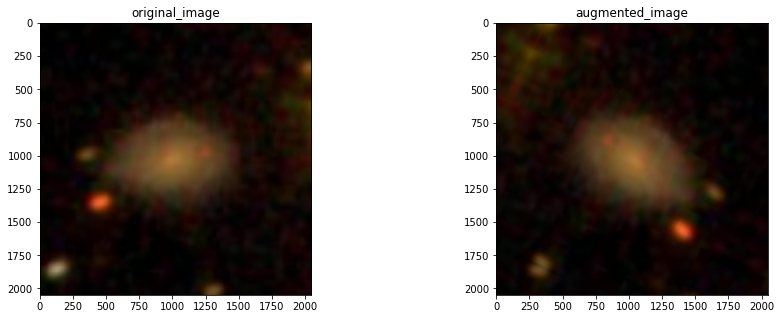

In [ ]:
generate_image(0,4, aug = True)

#### **Defining functions for code shortening**

In [ ]:
def generate_graph(model_training):
    plt.figure(figsize= (15,5))
    plt.subplot(1,2,1)
    plt.plot(model_training.history.history['accuracy'])
    plt.plot(model_training.history.history['val_accuracy'])
    plt.title('Training vs TestAccuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(('Training', 'Validation'), loc = 'best')
    plt.subplot(1,2,2)
    plt.plot(model_training.history.history['loss'])
    plt.plot(model_training.history.history['val_loss'])
    plt.title('Training loss vs Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(('Training', 'Validation'), loc = 'best')
    plt.show()

# Defining callbacks for the models
filepath = './custom_dnn'
reduced_lr = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.2, patience = 5, min_lr = 0.001) # This conssists of the default values
model_checkpoint  = tf.keras.callbacks.ModelCheckpoint(filepath =filepath,save_best_only=True, verbose = 1)
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10,verbose= 1, monitor = 'val_accuracy')
tensorboard_callback = tf.keras.callbacks.TensorBoard(histogram_freq=1)
callbacks = [reduced_lr, model_checkpoint, early_stopping ,tensorboard_callback]

def run_model(model_training, epochs = 50):
    optimizer = optimizers.Adam(learning_rate = 1e-3)
    model_training.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    print(model_training.summary())
    class_weight = {0:1.13, 1:8.03, 2:1} # this is done by dividing the total number of highest occurence of classes by that particul count of class
    model_training.fit(train_ds,validation_data=val_ds,epochs = epochs, verbose = 1, workers = 3, class_weight  = class_weight)
    generate_graph(model_training)

# optimizer = optimizers.Adam(lr = 1e-3)
# model4.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
# model4.summary()
# model4.fit(train_ds,validation_data=val_ds,epochs = 10, verbose = 1, workers = 3)

#### Baseline model - 128C - 256D - Adam - Accuracy

In [ ]:
def baseline_model(aug=False):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    if aug == True:
        model.add(layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
        model.add(layers.experimental.preprocessing.RandomRotation(0.2))
    model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
        
    model.add(Flatten())

    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    # Final layer
    model.add(Dense(num_classes, activation = 'softmax'))
    return model

model1 = baseline_model()
model1_aug = baseline_model(aug  = True)
    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)     

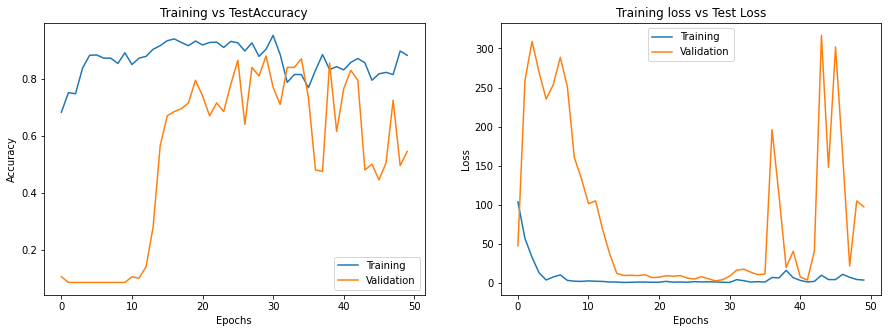

In [ ]:
run_model(model1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 512, 512, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 512, 512, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 64)     

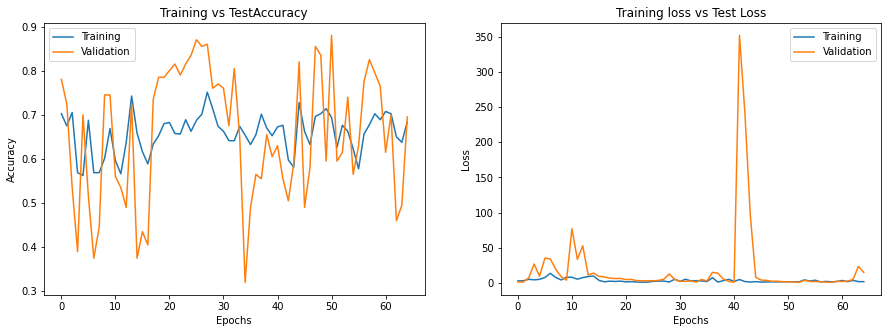

In [ ]:
run_model(model1_aug, epochs = 65)

#### Baseline model - 128C - 256/512D - Adam - Accuracy

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 128, 128, 64)     

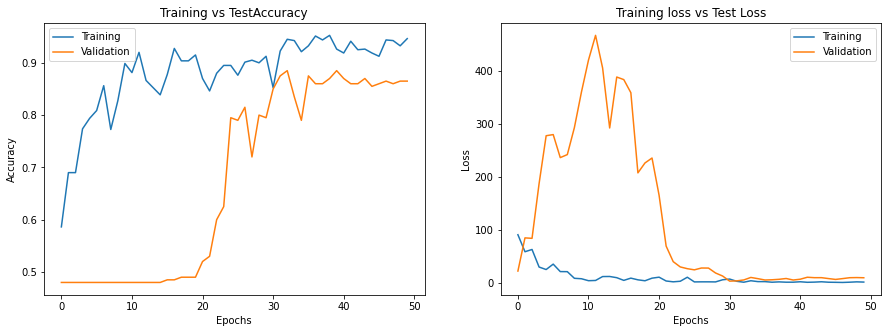

In [ ]:
def baseline_model(aug = False):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    if aug == True:
        model.add(layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
        model.add(layers.experimental.preprocessing.RandomRotation(0.2))
    model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
        
    model.add(Flatten())

    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))

    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.5))
    # Final layer
    model.add(Dense(num_classes, activation = 'softmax'))
    return model
    
model2 = baseline_model()
model2_aug = baseline_model(aug = True)
run_model(model2)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 512, 512, 3)       0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 512, 512, 3)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 256, 256, 64)     

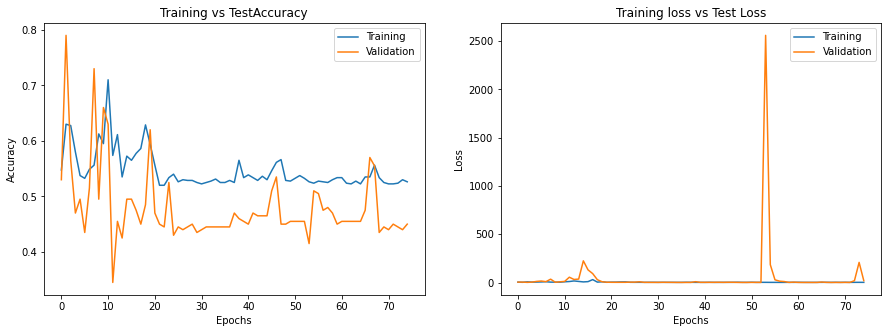

In [ ]:
run_model(model2_aug, epochs = 75)

#### Baseline model - 256C - 512D - Adam - Accuracy

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 64)     

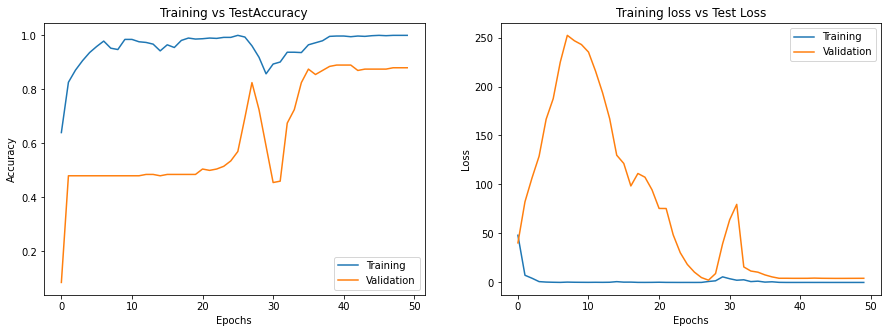

In [ ]:
def baseline_model(aug = False):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    if aug == True:
        model.add(layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
        # model.add(layers.experimental.preprocessing.RandomRotation(0.2))
    model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(256, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Flatten())

    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.2))
    # Final layer
    model.add(Dense(num_classes, activation = 'softmax'))
    return model
    
model3 = baseline_model()
run_model(model3)
    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 512, 512, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)     

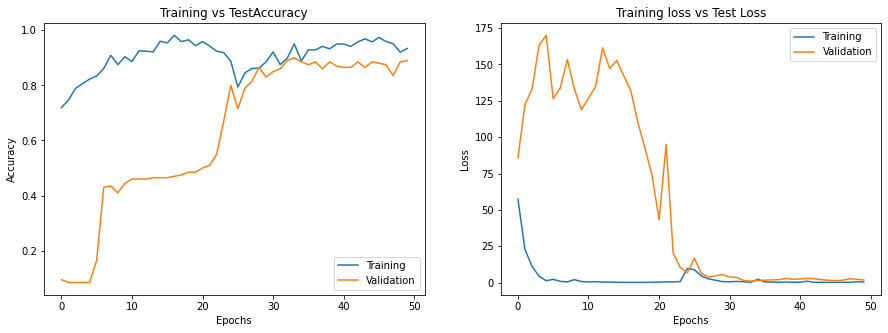

In [ ]:
def baseline_model(aug = False):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    if aug == True:
        model.add(layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
        # model.add(layers.experimental.preprocessing.RandomRotation(0.2))
    model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(256, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Flatten())

    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.2))
    # Final layer
    model.add(Dense(num_classes, activation = 'softmax'))
    return model
model3_aug = baseline_model(aug = True)
run_model(model3_aug)

In [ ]:
model3.evaluate(val_ds)

7/7 [==============================] - 0s 58ms/step - loss: 4.2316 - accuracy: 0.8800


[4.231595516204834, 0.8799999952316284]

In [ ]:
model3.predict(val_ds).argmax(axis=1)

array([0, 0, 0, 2, 0, 2, 0, 2, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0,
       0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2,
       2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 0, 0,
       0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 0, 2, 1, 2,
       0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0,
       0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 1,
       2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 1, 0,
       0, 1, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2,
       0, 2])

In [ ]:
base_model_effnet = tf.keras.applications.EfficientNetB2(
    include_top=False,
    weights="imagenet",    
    input_shape=(img_height, img_width, channels),
    pooling='max',
    classes=3,
)

In [ ]:
layer_count  = len(base_model_effnet.layers)
print(f'There are a total of {layer_count} layers in the EfficientNetB2 network')
# making the base layers non trainable or freezing
break_point  = 330
for layer in base_model_effnet.layers[0:break_point]:
    layer.trainable = False
for layer in base_model_effnet.layers[break_point:]:
    layer.trainable = True

# please note higher the break point ; lesser the trainable layers lesser is the over fitting -> high breakpoint -> less over fitting 
base_model_effnet.inputs

There are a total of 340 layers in the EfficientNetB2 network


[<KerasTensor: shape=(None, 512, 512, 3) dtype=float32 (created by layer 'input_3')>]

In [ ]:
input_layer = base_model_effnet.inputs
# Building a functional model

output = base_model_effnet.output
output


<KerasTensor: shape=(None, 1408) dtype=float32 (created by layer 'max_pool')>

In [ ]:
# ['GALAXY', 'QSO', 'STAR']
# 440,62,498
#1.13, 8.03, 1

In [ ]:
#### Cusstomized data augmentation of the dataset before feeding into layers unlike previous steps
rescale = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])
data_aug = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")])
batch_size =8
autotune = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'training',seed = 123, image_size = (img_width, img_height), 
                                                                  batch_size = batch_size, label_mode = 'categorical')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'validation',seed = 123, image_size = (img_width, img_height),
                                                                batch_size = batch_size, label_mode = 'categorical')

train_ds.map(lambda x,y: (rescale(x), y), num_parallel_calls=autotune)
val_ds.map(lambda x,y: (rescale(x), y), num_parallel_calls=autotune)
val_ds.prefetch(buffer_size=autotune)

def prepare_dataset(ds):
    ds = ds.map(lambda x, y : (data_aug(x, training = True), y), num_parallel_calls = autotune)
    return ds.prefetch(buffer_size =autotune)
    
# 25 batches of 32 each and 7 batches of 32 each
train_ds_aug = prepare_dataset(train_ds)

Found 1000 files belonging to 3 classes.
Using 800 files for training.
Found 1000 files belonging to 3 classes.
Using 200 files for validation.


In [ ]:
x = Dense(256, activation  = 'relu')(output)
x = Dense(num_classes, activation  = 'softmax')(x)

effnet_model = Model(inputs = input_layer, outputs = x)
effnet_model.summary()
effnet_model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'],)
1.13, 8.03, 1
class_weight = {0:1.13, 1:8.03, 2:1}


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 512, 512, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 512, 512, 3)  7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [ ]:
effnet_model_transfer = effnet_model.fit(train_ds,validation_data=val_ds,epochs = 20, verbose = 1, workers = 3, class_weight=class_weight)

Epoch 1/20
100/100 [==============================] - 563s 5s/step - loss: 9.9429 - accuracy: 0.4710 - val_loss: 1.1367 - val_accuracy: 0.7050
Epoch 2/20
100/100 [==============================] - 26s 254ms/step - loss: 5.9107 - accuracy: 0.5861 - val_loss: 2.6035 - val_accuracy: 0.5300
Epoch 3/20
100/100 [==============================] - 26s 255ms/step - loss: 6.1369 - accuracy: 0.5492 - val_loss: 1.3475 - val_accuracy: 0.7250
Epoch 4/20
100/100 [==============================] - 26s 254ms/step - loss: 2.1847 - accuracy: 0.7287 - val_loss: 1.8588 - val_accuracy: 0.6400
Epoch 5/20
100/100 [==============================] - 26s 255ms/step - loss: 2.9704 - accuracy: 0.6948 - val_loss: 4.2133 - val_accuracy: 0.4700
Epoch 6/20
100/100 [==============================] - 26s 254ms/step - loss: 4.6253 - accuracy: 0.6195 - val_loss: 2.0208 - val_accuracy: 0.7100
Epoch 7/20
100/100 [==============================] - 26s 254ms/step - loss: 2.1899 - accuracy: 0.7748 - val_loss: 0.6844 - val_accu

In [ ]:
effnet_model_transfer_aug = effnet_model.fit(train_ds_aug,validation_data=val_ds,epochs = 20, verbose = 1, workers = 3, class_weight=class_weight)

Epoch 1/20
100/100 [==============================] - 33s 228ms/step - loss: 15.3870 - accuracy: 0.3954 - val_loss: 0.6667 - val_accuracy: 0.7700
Epoch 2/20
100/100 [==============================] - 22s 208ms/step - loss: 3.7061 - accuracy: 0.5847 - val_loss: 0.9034 - val_accuracy: 0.7550
Epoch 3/20
100/100 [==============================] - 22s 209ms/step - loss: 3.5095 - accuracy: 0.6369 - val_loss: 2.3405 - val_accuracy: 0.6300
Epoch 4/20
100/100 [==============================] - 22s 208ms/step - loss: 4.3436 - accuracy: 0.5974 - val_loss: 0.9232 - val_accuracy: 0.8100
Epoch 5/20
100/100 [==============================] - 22s 208ms/step - loss: 2.5319 - accuracy: 0.6981 - val_loss: 0.8939 - val_accuracy: 0.8300
Epoch 6/20
100/100 [==============================] - 22s 208ms/step - loss: 1.5334 - accuracy: 0.7798 - val_loss: 1.4827 - val_accuracy: 0.7400
Epoch 7/20
100/100 [==============================] - 22s 205ms/step - loss: 3.2210 - accuracy: 0.6711 - val_loss: 0.9228 - val_a

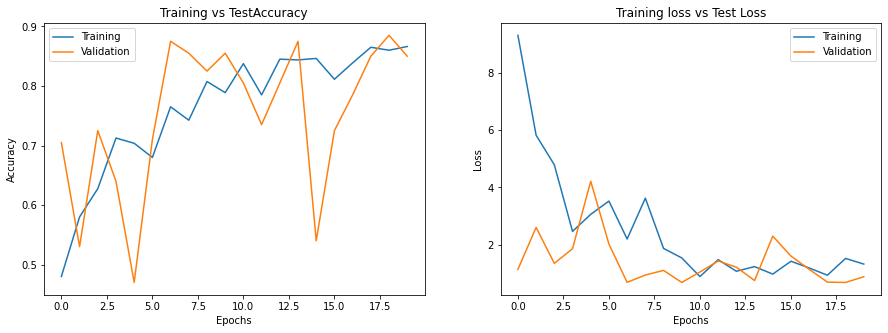

In [ ]:
generate_graph_transfer(effnet_model_transfer)

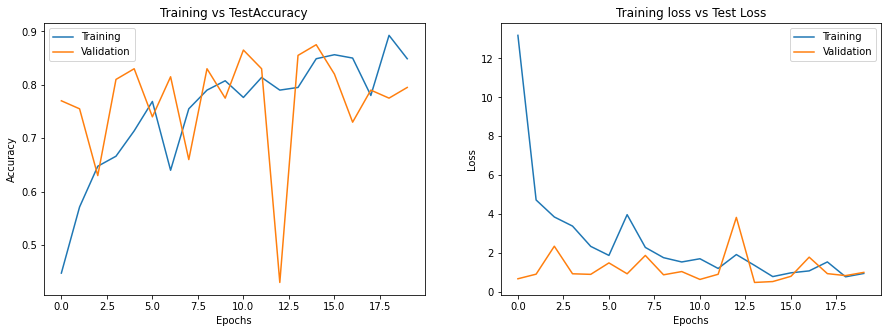

In [ ]:
generate_graph_transfer(effnet_model_transfer_aug)

In [ ]:
#### EfficientNet B2 - Google